# TTS Data A HDPE Resins 5 temperatures
### Osamu Katagiri-Tanaka <A01212611@itesm.mx>
---

In [1]:
# PYTHON LIBRARIES
%matplotlib inline

import pandas as pd
import numpy as np
import datetime
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from adjustText import adjust_text
from sklearn.preprocessing import LabelEncoder
number = LabelEncoder()
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
from sklearn.linear_model import LinearRegression

---
## function to plot a pandas dataframe

In [2]:
def plot(df, pltname, plotGs=True):
    # PLOT SETUP
    scale = 6;
    fig   = plt.figure(figsize=(3*scale, 2*scale));
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.tight_layout();

    for i in range(0,len(df.columns),3):
        # Define x axis as the date axis
        x_str  = df.columns[i];   x_units = r'$[\frac{rad}{s}]$';
        y1_str = df.columns[i+1]; y_units = r'$[Pa \cdot s]$';
        y2_str = df.columns[i+2];

        # Remove NANs from interesting x,y data
        df_fil = pd.DataFrame(df);
        df_fil = df_fil.dropna(subset=[x_str, y1_str, y2_str]);

        # Stablish the plot area
        ax0 = plt.gca()

        # Extract data from a specific country
        x  = df_fil.iloc[:][x_str];
        y1 = df_fil.iloc[:][y1_str];
        y2 = df_fil.iloc[:][y2_str];

        # Plot a curve to join the data points
        #plt.plot(x, y) #, label="B")
        if plotGs:
            plt.scatter(x, y1, s=45, marker='o', label=r'$G^\prime(\omega)$' + ' ' + df.columns[i+1].split('_')[1])
            plt.scatter(x, y2, s=45, marker='s', label=r'$G^{\prime\prime}(\omega)$' + ' ' + df.columns[i+2].split('_')[1])
            plt.plot(x, y1, linewidth=1, linestyle='-.')
            plt.plot(x, y2, linewidth=1, linestyle='-.')
        else:
            plt.scatter(x, y2/y1, s=45, marker='^', label=df.columns[i+1].split('_')[1])
            plt.plot(x, y2/y1, linewidth=1, linestyle=':')

    # Show the plot lengend to link colors and polymer names
    handles, labels = ax0.get_legend_handles_labels();
    lgd = dict(zip(labels, handles));

    # fig.autofmt_xdate();
    ax0.set_xlabel(r'$\omega$' + '    ' + x_units, fontsize=24);
    if plotGs:
        ax0.set_ylabel(r'$G^\prime(\omega)$'  + ' and ' +  r'$G^{\prime\prime}(\omega)$' + '    ' + y_units, fontsize=24);
    else:
        ax0.set_ylabel(r'$tan \delta$', fontsize=24);

    for tick in ax0.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    for tick in ax0.yaxis.get_major_ticks():
        tick.label.set_fontsize(18) 

    ax0.tick_params(which='both', direction='in', length=5, width=2, bottom=True, top=True, left=True, right=True)

    # Display main plot
    plt.yscale('log');
    plt.xscale('log');
    plt.legend(lgd.values(), lgd.keys(), prop={'size': 18}, loc="best");
    plt.title(pltname, size=24);
    plt.savefig(pltname + '.png', dpi=200, bbox_inches='tight');
    plt.show();
    mpl.rcParams.update(mpl.rcParamsDefault); # Recover matplotlib defaults

---
## WLF (Williams Landel Ferry)
$$ log a_T = \frac{- c_1 \left( T - T_0 \right)}{c_2 + \left( T - T_0 \right)} $$

where: <br>
$c_1$ and $c_2$ are empirical constants <br>
$T$ is the temperature of interest <br>
$T_0$ is the reference temperature <br>
$a_T$ is the amount by which the time has to be shifted to get the same result at $T$ as in $T_0$

In [3]:
def _a_T(T, T_0, c_1, c_2):
    if T != T_0:
        nume = - c_1 * (T - T_0);
        deno = c_2 + (T - T_0);
        exp  = nume / deno;
        a_T  = 10**exp;
    else:
        a_T = 1;
    return a_T;

def _invTninvT0(T,T_0):
    return (1/T)-(1/T_0)

---
## Arrhenius

$$ a_T = e^{\left[ \frac{E_H}{R} \left( \frac{1}{T + 273} - \frac{1}{T_0 + 273} \right) \right]} $$

In [4]:
def _Arrhenius(EH, T, T0):
    frac  = EH / 8.314;
    paren = (1/(T+273.15)) - (1/(T0+273.15));
    exp = frac * paren;
    return np.exp(exp);

---
## read .csv with the provided frequency, $G^\prime$, and $G^{\prime\prime}$ data

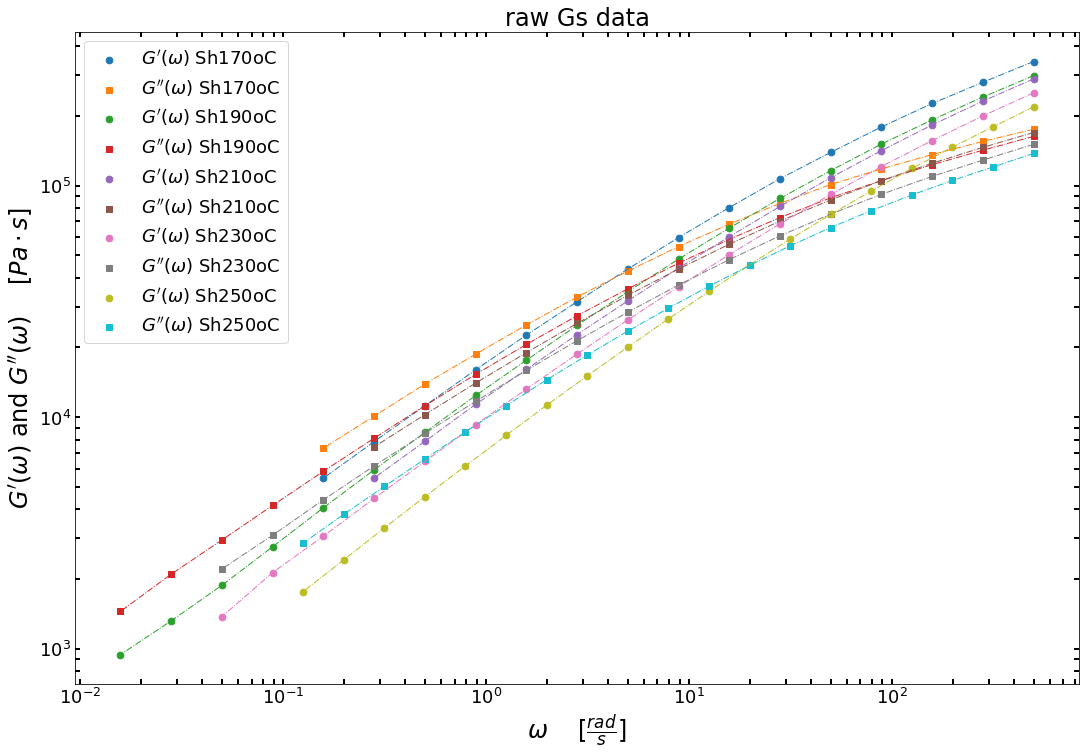

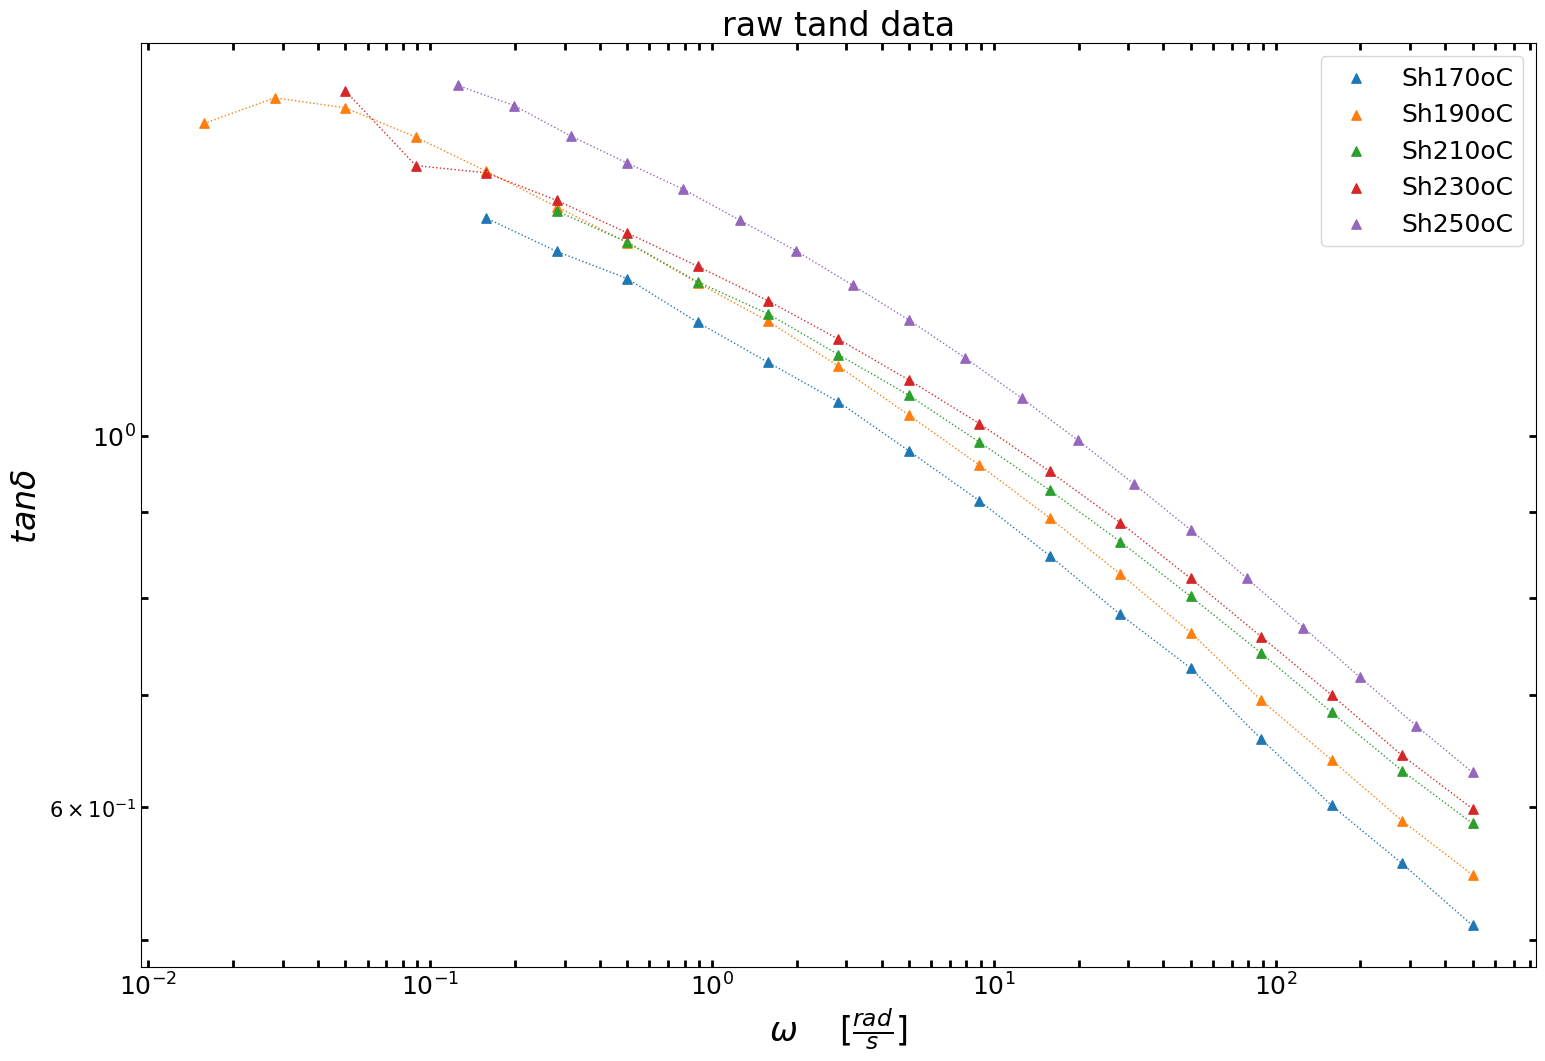

./data.csv


,frecuencia_Sh170oC,G1_Sh170oC,G2_Sh170oC,frecuencia_Sh190oC,G1_Sh190oC,G2_Sh190oC,frecuencia_Sh210oC_ref,G1_Sh210oC_ref,G2_Sh210oC_ref,frecuencia_Sh230oC,G1_Sh230oC,G2_Sh230oC,frecuencia_Sh250oC,G1_Sh250oC,G2_Sh250oC
0,500.00,343000.0,175000.0,500.00,298000.0,163000.0,500.00000,288545.0,169359.0,500.00000,251301.0,150515.0,500.00000,218582.0,137616.0
1,281.00,279000.0,155000.0,281.00,241000.0,142000.0,281.17200,231412.0,146049.0,281.17200,199744.0,128738.0,315.47700,179203.0,120310.0
2,158.00,226000.0,136000.0,158.00,192000.0,123000.0,158.11700,182623.0,124870.0,158.11700,156375.0,109503.0,199.05100,146499.0,105154.0
3,88.90,179000.0,118000.0,88.90,151000.0,105000.0,88.91600,141545.0,105000.0,88.91600,120746.0,91613.6,125.59200,118516.0,91057.7
4,50.00,139000.0,101000.0,50.00,116000.0,88500.0,50.00200,108073.0,86653.8,50.00200,91516.8,75213.8,79.24220,94743.1,77870.9
5,28.10,107000.0,83700.0,28.10,87900.0,72700.0,28.11870,81183.4,70188.5,28.11870,68305.9,60615.8,49.99800,74972.2,65873.4
6,15.80,80300.0,68100.0,15.80,65500.0,58500.0,15.81250,60144.9,55798.1,15.81250,50295.8,47883.3,31.54640,58668.4,54882.0
7,8.89,59600.0,54500.0,8.89,48100.0,46200.0,8.89209,43975.3,43587.8,8.89209,36564.7,37176.9,19.90430,45439.3,45151.8
8,5.00,43600.0,42700.0,5.00,34800.0,35800.0,5.00049,31760.0,33575.1,5.00049,26301.9,28394.4,12.55860,34878.8,36729.0
9,2.81,31500.0,33000.0,2.81,24900.0,27400.0,2.81201,22724.8,25403.8,2.81201,18728.2,21383.5,7.92395,26547.3,29542.2


In [5]:
df_raw = pd.read_csv("./data.csv", delimiter=",");
plot(df_raw, "raw Gs data", True)
plot(df_raw, "raw tand data", False)
print("./data.csv"); display(df_raw.head(10));

---
## calculate WLF for each temperature and plot shifted data
### master curve with $T_{ref} = 210 °C$

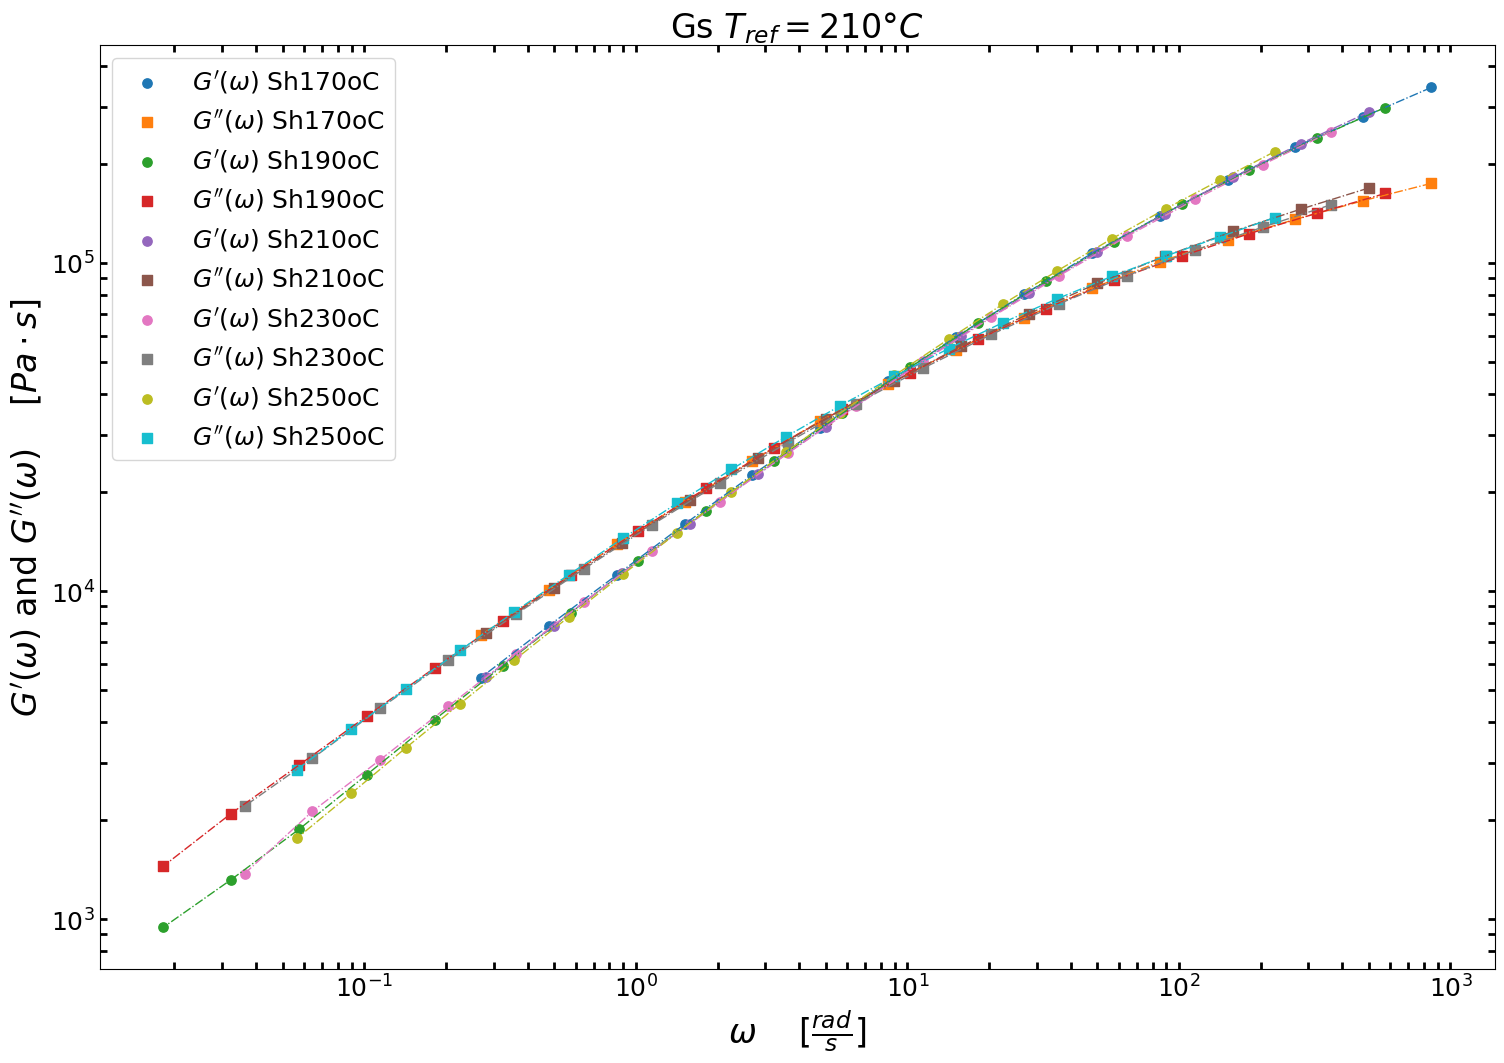

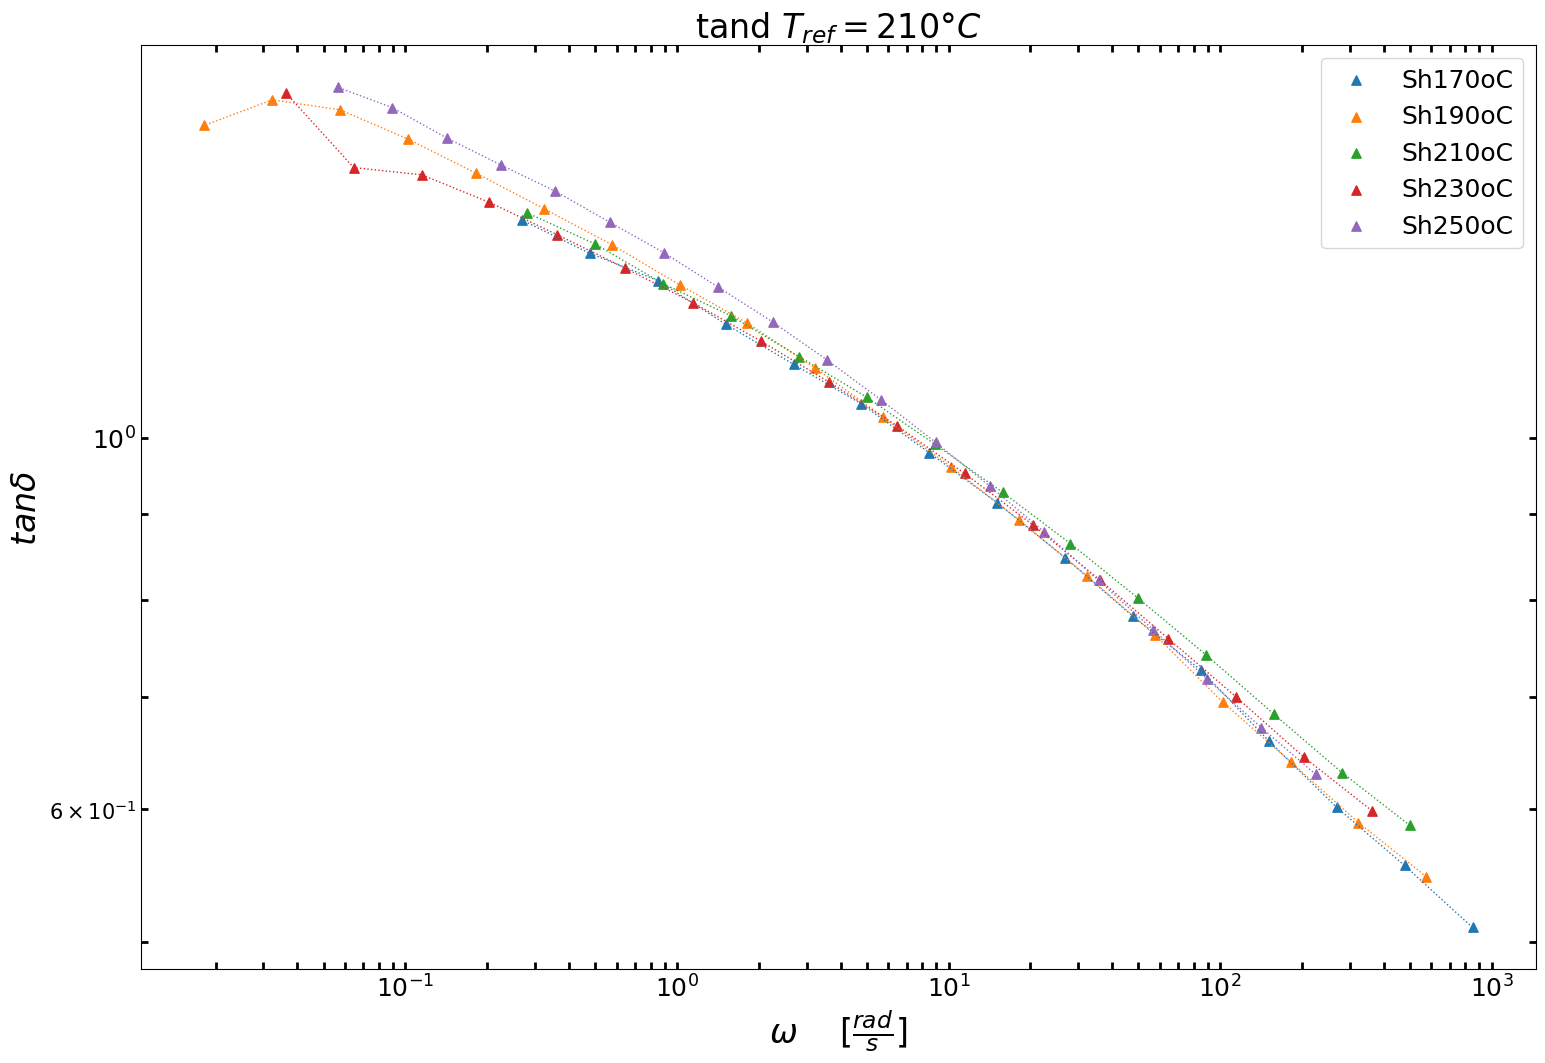

df_shifted


,frecuencia_Sh170oC,G1_Sh170oC,G2_Sh170oC,frecuencia_Sh190oC,G1_Sh190oC,G2_Sh190oC,frecuencia_Sh210oC_ref,G1_Sh210oC_ref,G2_Sh210oC_ref,frecuencia_Sh230oC,G1_Sh230oC,G2_Sh230oC,frecuencia_Sh250oC,G1_Sh250oC,G2_Sh250oC
0,850.000,343000.0,175000.0,575.0000,298000.0,163000.0,500.00000,288545.0,169359.0,362.500000,251301.0,150515.0,225.000000,218582.0,137616.0
1,477.700,279000.0,155000.0,323.1500,241000.0,142000.0,281.17200,231412.0,146049.0,203.849700,199744.0,128738.0,141.964650,179203.0,120310.0
2,268.600,226000.0,136000.0,181.7000,192000.0,123000.0,158.11700,182623.0,124870.0,114.634825,156375.0,109503.0,89.572950,146499.0,105154.0
3,151.130,179000.0,118000.0,102.2350,151000.0,105000.0,88.91600,141545.0,105000.0,64.464100,120746.0,91613.6,56.516400,118516.0,91057.7
4,85.000,139000.0,101000.0,57.5000,116000.0,88500.0,50.00200,108073.0,86653.8,36.251450,91516.8,75213.8,35.658990,94743.1,77870.9
5,47.770,107000.0,83700.0,32.3150,87900.0,72700.0,28.11870,81183.4,70188.5,20.386057,68305.9,60615.8,22.499100,74972.2,65873.4
6,26.860,80300.0,68100.0,18.1700,65500.0,58500.0,15.81250,60144.9,55798.1,11.464062,50295.8,47883.3,14.195880,58668.4,54882.0
7,15.113,59600.0,54500.0,10.2235,48100.0,46200.0,8.89209,43975.3,43587.8,6.446765,36564.7,37176.9,8.956935,45439.3,45151.8
8,8.500,43600.0,42700.0,5.7500,34800.0,35800.0,5.00049,31760.0,33575.1,3.625355,26301.9,28394.4,5.651370,34878.8,36729.0
9,4.777,31500.0,33000.0,3.2315,24900.0,27400.0,2.81201,22724.8,25403.8,2.038707,18728.2,21383.5,3.565777,26547.3,29542.2


In [6]:
df_shifted = pd.read_csv("./data.csv", delimiter=",");

# Temperature of interest
T = [170, 190, 210, 230, 250];

# Reference temperature
T_0 = 210;

# k was manually tuned TTS
k = [1.7, 1.15, 1, 0.725, 0.45];
# k = [2.1, 1.3, 1, 0.9, 0.45];

# 1st empiric constant used by WLF
c_1 = 10;

for col in range(0,len(df_shifted.columns),3):
    index = int(col/3); # index with +3 increments
    
    # 2nd empiric constant used by WLF
    c_2 = -((c_1 * (T[index] - T_0))/(np.log10(k[index]))) - T[index] + T_0;
    
    # Amount of horizontal shift by WLF
    a_T = _a_T(T[index], T_0, c_1, c_2);
    
    # Apply a_T to the original data
    df_shifted.iloc[: , col] = df_shifted.iloc[: , col] * a_T;

# Plot and print calculated data
plot(df_shifted, 'Gs ' + r'$T_{ref} = 210 °C$', True)
plot(df_shifted, 'tand ' + r'$T_{ref} = 210 °C$', False)
print("df_shifted"); display(df_shifted.head(10));

---
## Calculate the activation energy $E_a$

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

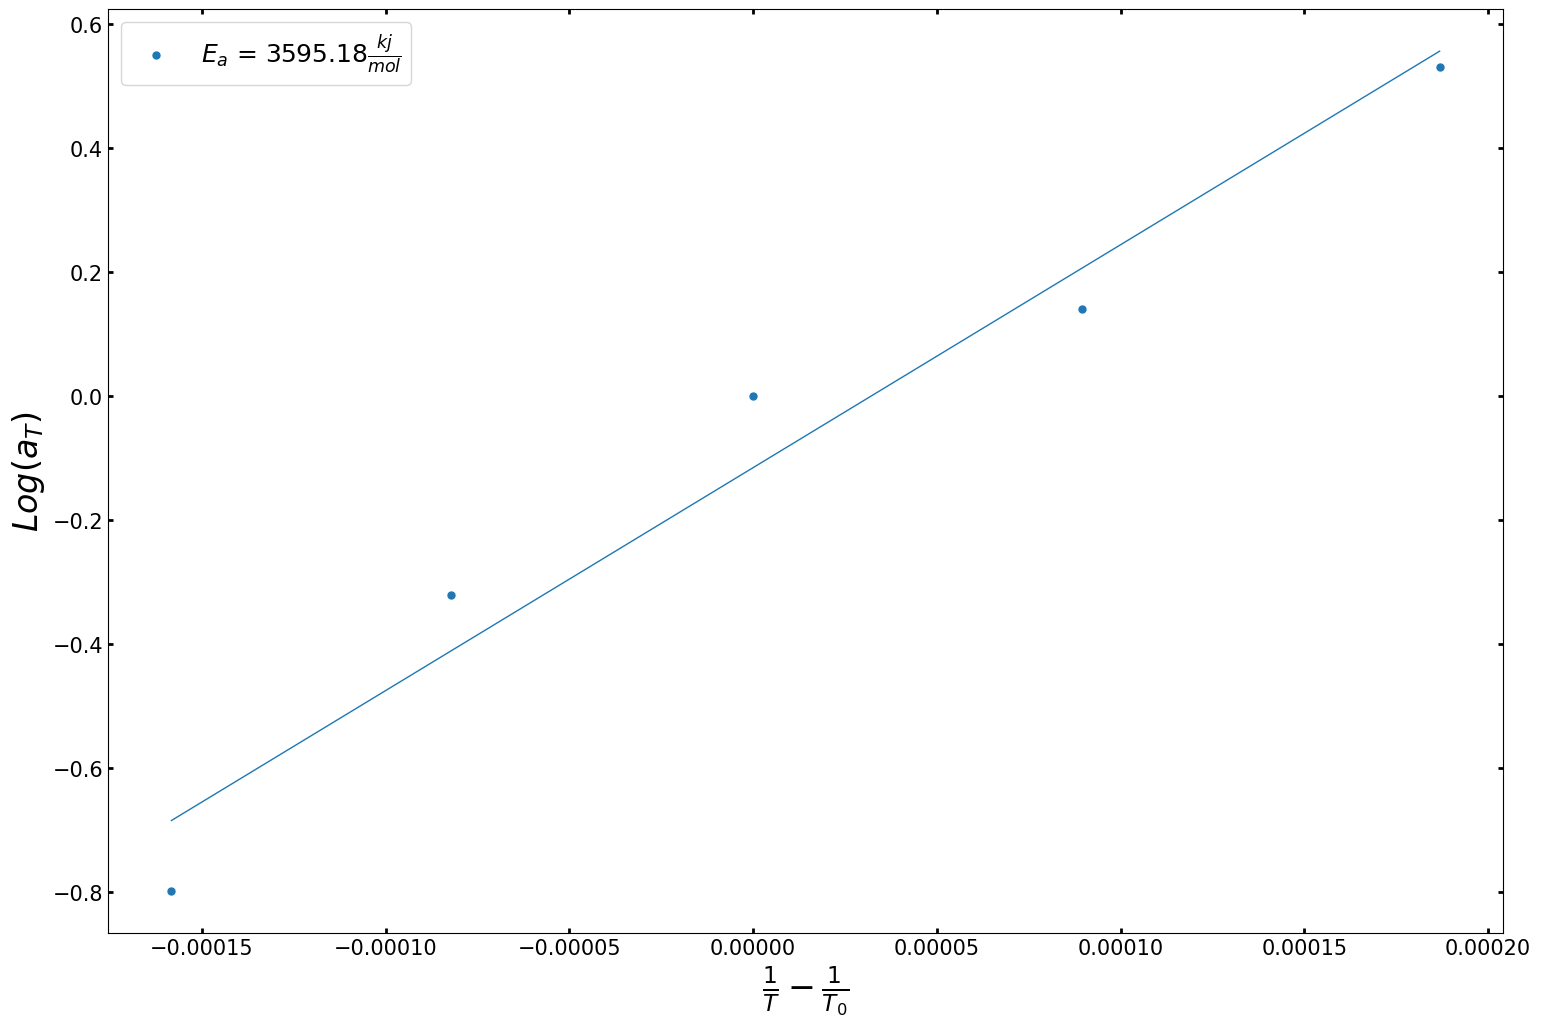

In [7]:
invTninvT0 = _invTninvT0(pd.Series(T)+273.15,T_0+273.15)

# PLOT SETUP
scale = 6;
fig   = plt.figure(figsize=(3*scale, 2*scale));
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.tight_layout();
ax0 = plt.gca()

b = [];
x = invTninvT0;
y = np.log(k);  
model = LinearRegression().fit(np.array(x).reshape((-1, 1)), np.array(y));
plt.scatter(x, y, s=25, label=r'$E_a$' + " = " + str(round(model.coef_[0], 2)) + r'$\frac{kj}{mol}$');
plt.plot(x, model.predict(np.array(x).reshape((-1, 1))), linewidth=1);
    
b = b + model.coef_;
    
ax0.tick_params(which='both', direction='in', width=2, bottom=True, top=True, left=True, right=True);

# Display plots
plt.yscale('linear');
plt.xscale('linear');
plt.xlabel(r'$\frac{1}{T} - \frac{1}{T_0}$', fontsize=24);
plt.ylabel(r'$Log(a_T)$', fontsize=24);
# plt.title(plotname, size=24);
plt.legend(prop={'size': 18});
plt.savefig('plt_' + "Capillary rheometer correction" + '.png', dpi=300, bbox_inches='tight');
display(plt);
mpl.rcParams.update(mpl.rcParamsDefault); # Recover matplotlib defaults

---
## Calculate $E_H$

### $$ E_H = \frac{E_a}{R} $$
### $$ E_H = 432.424 \frac{kj}{mol} $$

In [8]:
3595.18/8.314

432.42482559538126

---
## Merge the data into three columns (frequency, G1, G2).

In [9]:
frequency = [];
G1        = [];
G2        = [];

for col in range(0,len(df_shifted.columns),3):
    
    # Extract dataframe from shifted curves
    x_str  = df_shifted.columns[col];
    y1_str = df_shifted.columns[col+1];
    y2_str = df_shifted.columns[col+2];
    
    # Remove NANs from interesting x,y data
    df_fil = pd.DataFrame(df_shifted);
    df_fil = df_fil.dropna(subset=[x_str, y1_str, y2_str]);
    
    # Extract data by column
    x  = df_fil.iloc[:][x_str];
    y1 = df_fil.iloc[:][y1_str];
    y2 = df_fil.iloc[:][y2_str];
    
    # Place the extracted data into lists
    frequency.extend(x.tolist())
    G1.extend(y1.tolist())
    G2.extend(y2.tolist())

# Use the list to create a new dataframe with sorted values
# (combine/merge columns with similar names)
df_mc = pd.DataFrame();
df_mc['frequency'] = frequency;
df_mc['G1_'] = G1;
df_mc['G2_'] = G2;
df_mc = df_mc.sort_values('frequency');

---
## Plot the viscosity curve at 205 C.

In [10]:
# Calculate the shifting factor to 205 C
EH = 432.424;
T  = 205;
T0 = 210;
Arrhenius = _Arrhenius(EH, T, T_0);
print(Arrhenius)

1.0011263363392033


<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

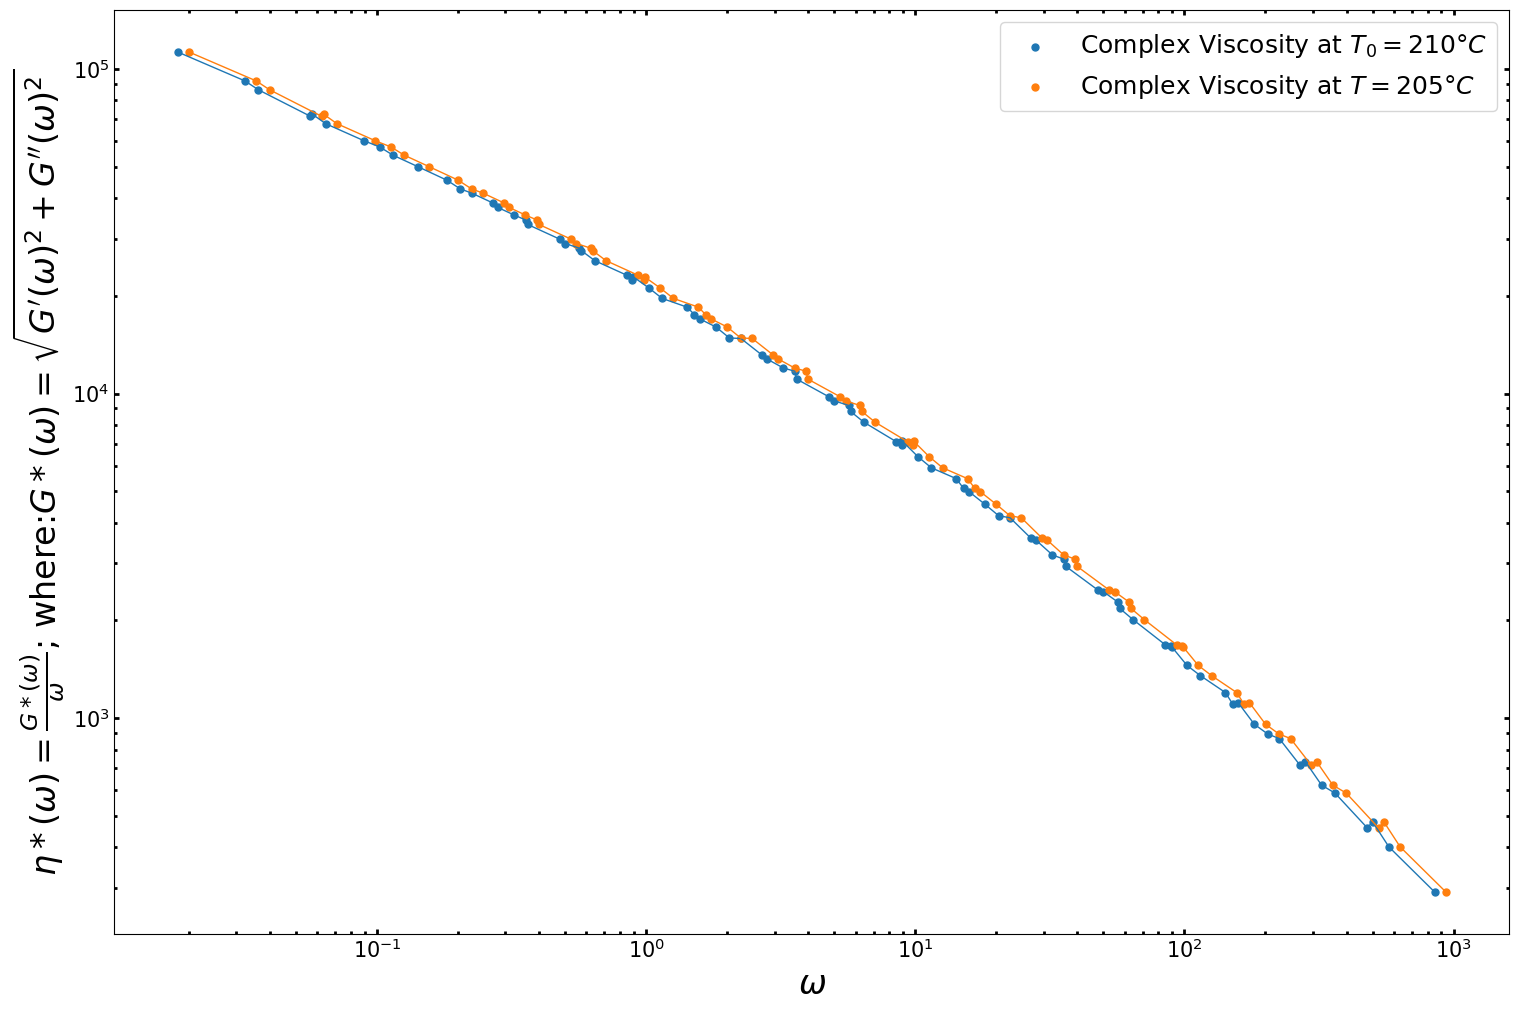

In [12]:
# PLOT SETUP
scale = 6;
fig   = plt.figure(figsize=(3*scale, 2*scale));
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.tight_layout();
ax0 = plt.gca()

b = [];
x = df_mc['frequency'];
y = np.sqrt(df_mc['G2_']**2 + df_mc['G2_']**2)/df_mc['frequency'];
plt.scatter(x, y, s=25, label="Complex Viscosity at " + r'$T_0 = 210 °C$');
plt.scatter(x*(Arrhenius+0.1), y, s=25, label="Complex Viscosity at " + r'$T = 205 °C$');
plt.plot(x, y, linewidth=1);
plt.plot(x*(Arrhenius+0.1), y, linewidth=1);
    
ax0.tick_params(which='both', direction='in', width=2, bottom=True, top=True, left=True, right=True);

# Display plots
plt.yscale('log');
plt.xscale('log');
plt.xlabel(r'$\omega$', fontsize=24);
plt.ylabel(r'$\eta*(\omega) = \frac{G*(\omega)}{\omega}$' + "; where:" + r'$G*(\omega) = \sqrt{G^{\prime}(\omega)^2 + G^{\prime\prime}(\omega)^2}$', fontsize=24);
# plt.title(plotname, size=24);
plt.legend(prop={'size': 18});
plt.savefig('plt_' + "Capillary rheometer correction" + '.png', dpi=300, bbox_inches='tight');
display(plt);
mpl.rcParams.update(mpl.rcParamsDefault); # Recover matplotlib defaults

---
* J. Ahmed, Time–Temperature Superposition Principle and its Application to Biopolymer and Food Rheology, in: Adv. Food Rheol. Its Appl., Elsevier, 2017: pp. 209–241. https://doi.org/10.1016/B978-0-08-100431-9.00009-7.
* A. Oseli, A. Aulova, M. Gergesova, I. Emri, Time-Temperature Superposition in Linear and Non-linear Domain, Mater. Today Proc. 3 (2016) 1118–1123. https://doi.org/10.1016/j.matpr.2016.03.059.
* H. Mavridis, R.N. Shroff, Temperature dependence of polyolefin melt rheology, Polym. Eng. Sci. 32 (1992) 1778–1791. https://doi.org/10.1002/pen.760322307.